# Multivariate Linear Regression using Gradient Descent

## Getting Ready

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
sns.set_style('darkgrid')

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/mk-gurucharan/Regression/master/Startups_Data.csv')

## Exploratory Data Analysis

Before using the data, we need to have a knowledge about the data in advance.

In [4]:
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [5]:
df.tail()

,R&D Spend,Administration,Marketing Spend,State,Profit
45,1000.23,124153.04,1903.93,New York,64926.08
46,1315.46,115816.21,297114.46,Florida,49490.75
47,0.00,135426.92,0.00,California,42559.73
48,542.05,51743.15,0.00,New York,35673.41
49,0.00,116983.80,45173.06,California,14681.40


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
R&D Spend,50.0,73721.6156,45902.256482,0.00,39936.3700,73051.080,101602.8000,165349.20
Administration,50.0,121344.6396,28017.802755,51283.14,103730.8750,122699.795,144842.1800,182645.56
Marketing Spend,50.0,211025.0978,122290.310726,0.00,129300.1325,212716.240,299469.0850,471784.10
Profit,50.0,112012.6392,40306.180338,14681.40,90138.9025,107978.190,139765.9775,192261.83


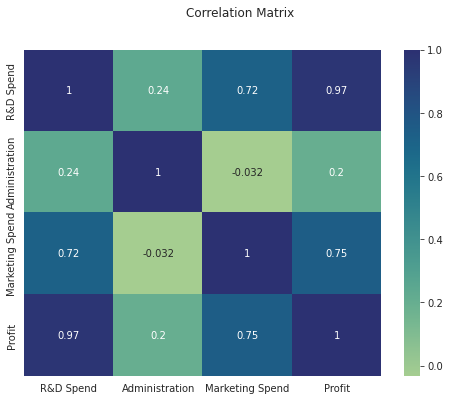

In [8]:
fig, ax = plt.subplots(1, 1,
                       figsize=(8, 6))
fig.suptitle('Correlation Matrix')

sns.heatmap(df.corr(), cmap='crest', annot=True, ax=ax)
plt.show()

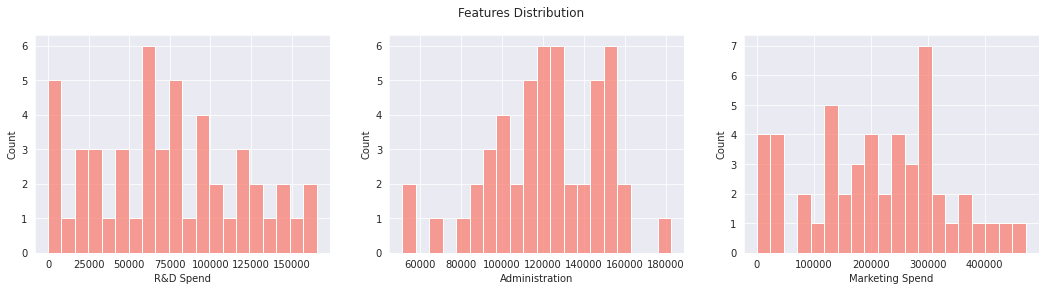

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, 
                                    figsize=(18, 4))
fig.suptitle('Features Distribution')

sns.histplot(df['R&D Spend'], ax=ax1, bins=20, color='salmon', kde=False)
sns.histplot(df['Administration'], ax=ax2, bins=20, color='salmon', kde=False)
sns.histplot(df['Marketing Spend'], ax=ax3, bins=20, color='salmon', kde=False)
plt.show()

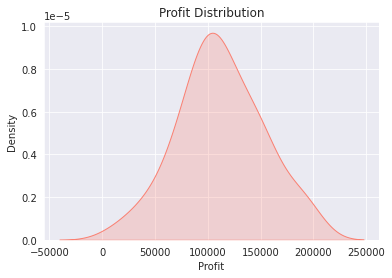

In [10]:
sns.kdeplot(df['Profit'], color='salmon', shade=True)
plt.title('Profit Distribution')
plt.show()

## Data Preprocessing

### Splitting Data into Features and Target

In [11]:
X = df.drop('Profit', axis=1)
y = df['Profit']

In [12]:
X.head(10)

,R&D Spend,Administration,Marketing Spend,State
0,165349.20,136897.80,471784.10,New York
1,162597.70,151377.59,443898.53,California
2,153441.51,101145.55,407934.54,Florida
3,144372.41,118671.85,383199.62,New York
4,142107.34,91391.77,366168.42,Florida
5,131876.90,99814.71,362861.36,New York
6,134615.46,147198.87,127716.82,California
7,130298.13,145530.06,323876.68,Florida
8,120542.52,148718.95,311613.29,New York
9,123334.88,108679.17,304981.62,California


### Categorical Encoding

In [13]:
encoder = LabelEncoder()
X['State'] = encoder.fit_transform(X['State'])

X.head(10)

,R&D Spend,Administration,Marketing Spend,State
0,165349.20,136897.80,471784.10,2
1,162597.70,151377.59,443898.53,0
2,153441.51,101145.55,407934.54,1
3,144372.41,118671.85,383199.62,2
4,142107.34,91391.77,366168.42,1
5,131876.90,99814.71,362861.36,2
6,134615.46,147198.87,127716.82,0
7,130298.13,145530.06,323876.68,1
8,120542.52,148718.95,311613.29,2
9,123334.88,108679.17,304981.62,0


### Feature Scaling

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:10]

array([[ 2.01641149,  0.56075291,  2.15394309,  1.21267813],
       [ 1.95586034,  1.08280658,  1.9236004 , -1.21267813],
       [ 1.75436374, -0.72825703,  1.62652767,  0.        ],
       [ 1.55478369, -0.09636463,  1.42221024,  1.21267813],
       [ 1.5049372 , -1.07991935,  1.28152771,  0.        ],
       [ 1.27980001, -0.77623907,  1.25421046,  1.21267813],
       [ 1.34006641,  0.93214721, -0.68814993, -1.21267813],
       [ 1.24505666,  0.87198001,  0.93218598,  0.        ],
       [ 1.03036886,  0.9869521 ,  0.83088691,  1.21267813],
       [ 1.09181921, -0.45664025,  0.77610744, -1.21267813]])

## Modeling

We define the functions necessary for the calculation of gradient descent including the loss function which we'll use the Mean Squared Error (MSE) loss function.

In [15]:
def predict(weight, X, bias):
  y_pred = []
  for i in range(len(X)):
    y_pred.append(np.dot(weight, X[i]) + bias)
  return np.array(y_pred)

def derivative_weight(X, y, y_pred):
  m = len(y)
  sum = 0
  for i in range(m):
    sum += -X[i] * (y[i] - y_pred[i])
  return (2 / m) * sum

def derivative_bias(y, y_pred):
  m = len(y)
  sum = 0
  for i in range(m):
    sum += -(y[i] - y_pred[i])
  return (2 / m) * sum

def mse(y, y_pred):
  return np.square(np.subtract(y, y_pred)).mean()

def gradient_descent(X, y, learning_rate=0.001, epochs=5000):
  weight = np.random.randn(X.shape[1])
  bias = 0
  error = []
  for _ in range(epochs):
    y_pred = predict(weight, X, bias)
    weight = weight - learning_rate * derivative_weight(X, y, y_pred)
    bias = bias - learning_rate * derivative_bias(y, y_pred)
    error.append(mse(y, y_pred))
  sns.lineplot(x=np.arange(1, epochs), y=error[1:])
  plt.xlabel('Number of Epochs')
  plt.ylabel('Error/Loss')
  plt.show()
  return weight, bias

We can now find the final weight and bias by using the functions we defined beforehand and proceed to modeling.

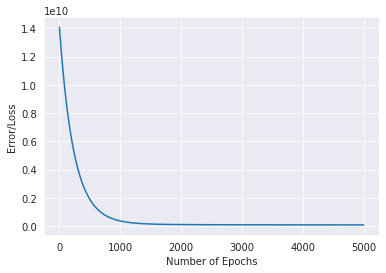

Weight: [34868.52248058  -130.6821363   4948.80189474    42.7147078 ]
Bias: 112007.6045015152


In [16]:
weight, bias = gradient_descent(X_scaled, y)
print(f'Weight: {weight}')
print(f'Bias: {bias}')

## Model Prediction

With the weight and bias, we can now use our model to predict the profit.

In [17]:
y_pred = []
for i in range(len(X_scaled)):
  y_pred.append(np.dot(weight, X_scaled[i]) + bias)

To visualize side-to-side with the actual profit, we store the actual profit with our prediction results in a DataFrame.

In [18]:
results_df = pd.DataFrame({
    'y': y,
    'y_pred': np.round(y_pred, 2)
})

results_df

,y,y_pred
0,192261.83,192954.85
1,191792.06,189531.78
2,191050.39,181324.21
3,182901.99,173323.24
4,166187.94,170965.69
5,156991.12,162992.42
6,156122.51,155154.61
7,155752.60,159920.14
8,152211.77,151969.76
9,149759.96,153926.40


Plotting the results would give us an easier time to visualize our model prediction compared to the actual profits.

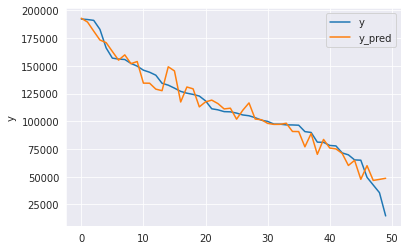

In [19]:
sns.lineplot(x=np.arange(0, 50), y=results_df['y'], label='y')
sns.lineplot(x=np.arange(0, 50), y=results_df['y_pred'], label='y_pred')
plt.legend()
plt.show()

## Evaluation

Here, we use the Mean Squared Error (MSE) loss function to calculate our prediction loss.

In [20]:
print(f'Loss: {mse(y, y_pred)}')

Loss: 79807575.1870973
